In [163]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [164]:
# Load dữ liệu từ PDD.csv
df = pd.read_csv("PDD.csv")
PDD = df.iloc[:, 0].to_numpy()  # 48 giá trị độ sâu
matrix_R = df.iloc[:, 1:].to_numpy()  # Ma trận R (48 x 201)

In [165]:
# Hàm để tính phổ năng lượng
def modify_approximated_landau(E, I0, A, Ep, w): 
    z = 2 * (Ep - E) / w 
    I = I0 + A * np.exp(-0.5 * np.exp(-z) - 0.5 * z) 
    return I

# Thiết lập các giá trị năng lượng từ 1 MeV đến 11 MeV với bước nhảy 0.05 MeV
E_values = np.arange(1, 11.05, 0.05)  # 201 giá trị năng lượng

In [166]:
# Hàm tạo dữ liệu huấn luyện với các phổ năng lượng và giá trị PDD tương ứng sử dụng matrix_R
def generate_training_data(num_samples):
    X_train = []
    Y_train = []
    
    for _ in range(num_samples):
        # Tạo các tham số ngẫu nhiên trong các khoảng giá trị mới
        I0 = np.random.uniform(0.000001, 0.0003)
        A = np.random.uniform(0.01, 0.1)
        Ep = np.random.uniform(1, 11)
        w = np.random.uniform(0.001, 0.1)
        
        # Tạo phổ năng lượng từ các tham số
        spectrum = modify_approximated_landau(E_values, I0, A, Ep, w)
        spectrum /= np.sum(spectrum)  # Chuẩn hóa phổ năng lượng để tổng diện tích bằng 1

        # Tính toán PDD tương ứng với phổ năng lượng sử dụng matrix_R
        PDD_calculated = np.dot(matrix_R, spectrum)  # Tính PDD từ phổ năng lượng
        
        # Thêm nhiễu Gaussian vào PDD
        noise = np.random.normal(0, 0.03, PDD_calculated.shape)  # Tạo nhiễu với trung bình 0 và độ lệch chuẩn 0.05
        PDD_noisy = PDD_calculated + noise  # Thêm nhiễu vào PDD

        # Thêm dữ liệu vào tập huấn luyện
        X_train.append(PDD_noisy)  # Giá trị PDD có nhiễu
        Y_train.append([I0, A, Ep, w])  # Các tham số đầu ra cần dự đoán

    return np.array(X_train), np.array(Y_train)

# Sinh dữ liệu huấn luyện
num_samples = 50000
X_train, Y_train = generate_training_data(num_samples)

# Chuẩn hóa dữ liệu đầu vào X_train
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)


C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_28016\1248858297.py:4: RuntimeWarning: overflow encountered in exp
  I = I0 + A * np.exp(-0.5 * np.exp(-z) - 0.5 * z)


In [168]:
X_train.shape

(50000, 48)

In [169]:
# Xây dựng mô hình mạng neural
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(4, activation='linear')  # Dự đoán các tham số I0, A, Ep, w
])

# Compile mô hình với Adam optimizer và learning_rate
learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Thiết lập EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Huấn luyện mô hình với EarlyStopping
history = model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping])

#

Epoch 1/500


c:\Users\MSI GS66\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.6046 - val_loss: 7.9032
Epoch 2/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0547 - val_loss: 1.6191
Epoch 3/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3654 - val_loss: 0.9896
Epoch 4/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9261 - val_loss: 0.8390
Epoch 5/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8079 - val_loss: 0.7437
Epoch 6/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7321 - val_loss: 0.6619
Epoch 7/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6434 - val_loss: 0.5890
Epoch 8/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5593 - val_loss: 0.5277
Epoch 9/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5119 - val_loss: 0.4764
Epoch 10/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4652 - val_loss: 0.4351
Epoch 11/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4193 - val_loss: 0.4014
Epoch 12/500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

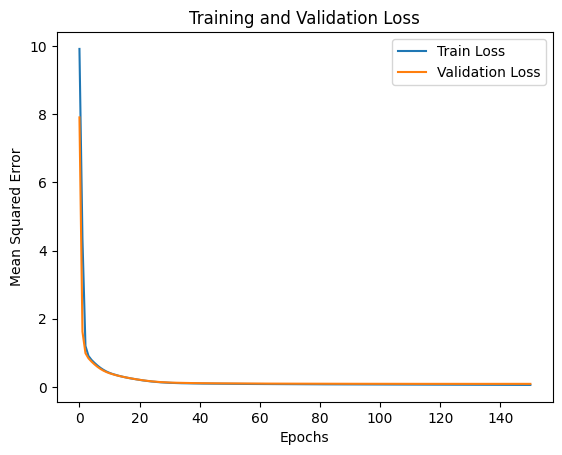

In [170]:
# Vẽ biểu đồ loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


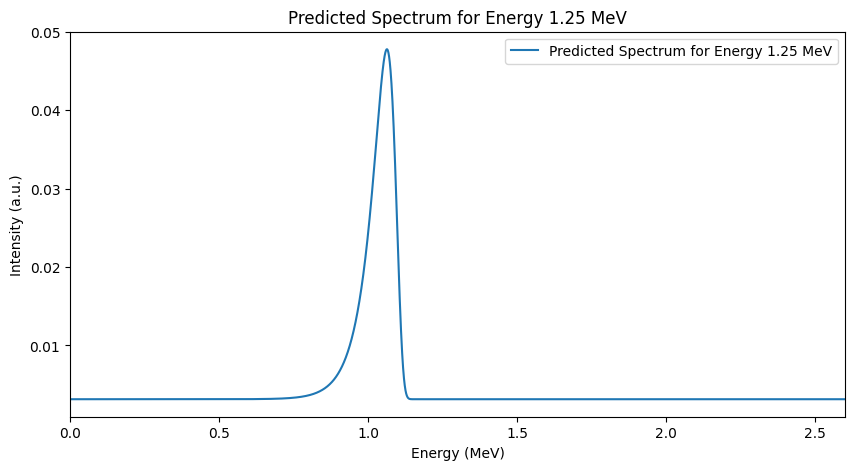

Predicted Parameters for Test Sample 1: I0=0.0031355544924736023, A=0.07358826696872711, Ep=1.0631039142608643, w=0.052556782960891724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


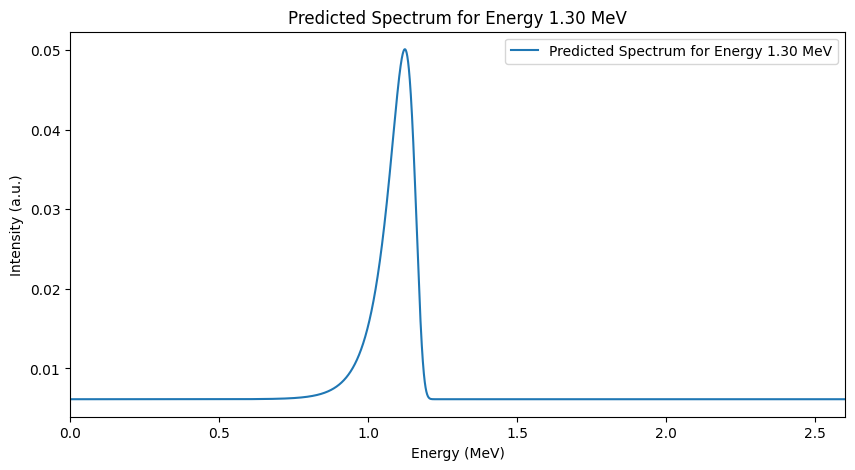

Predicted Parameters for Test Sample 2: I0=0.006137164309620857, A=0.07247181981801987, Ep=1.1233532428741455, w=0.06001663953065872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


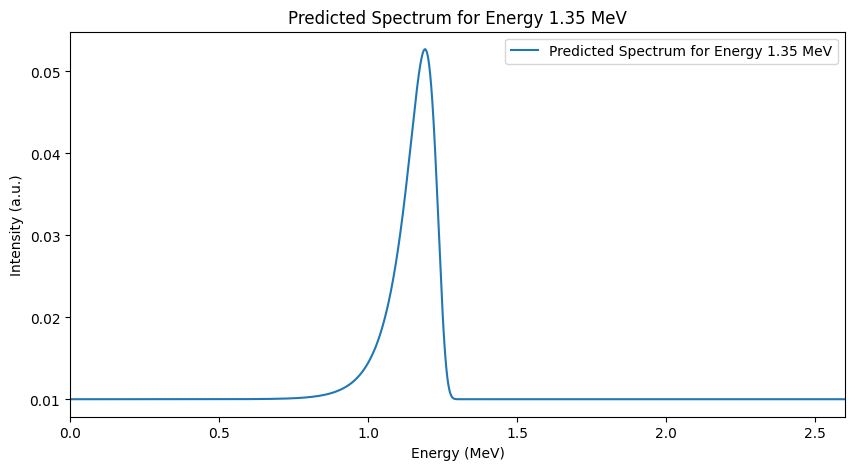

Predicted Parameters for Test Sample 3: I0=0.010027758777141571, A=0.07037656009197235, Ep=1.1909494400024414, w=0.06910251080989838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


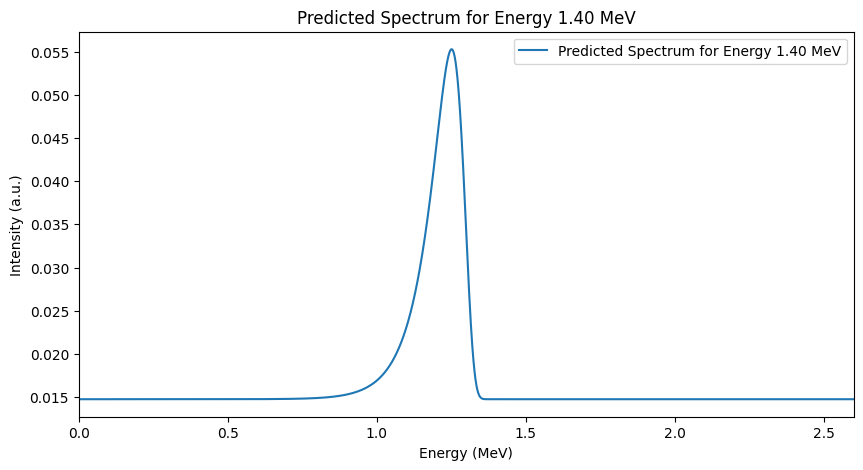

Predicted Parameters for Test Sample 4: I0=0.01475980132818222, A=0.06679775565862656, Ep=1.2508232593536377, w=0.0731542631983757
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


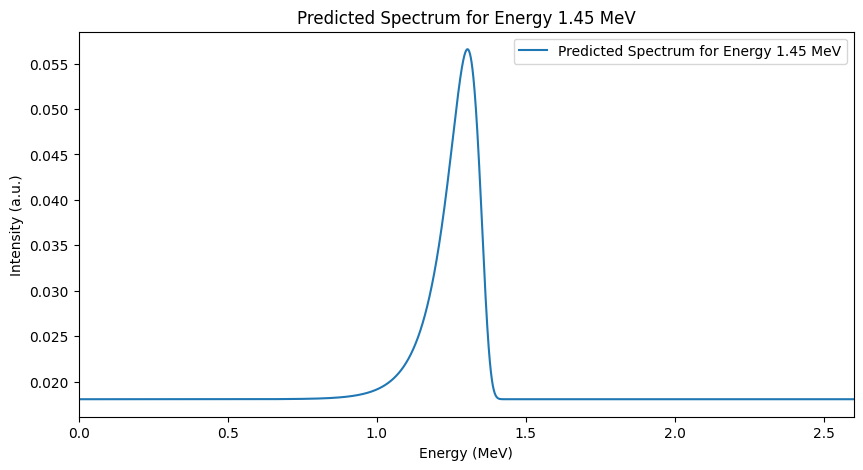

Predicted Parameters for Test Sample 5: I0=0.018050817772746086, A=0.06353285908699036, Ep=1.3045116662979126, w=0.07459964603185654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


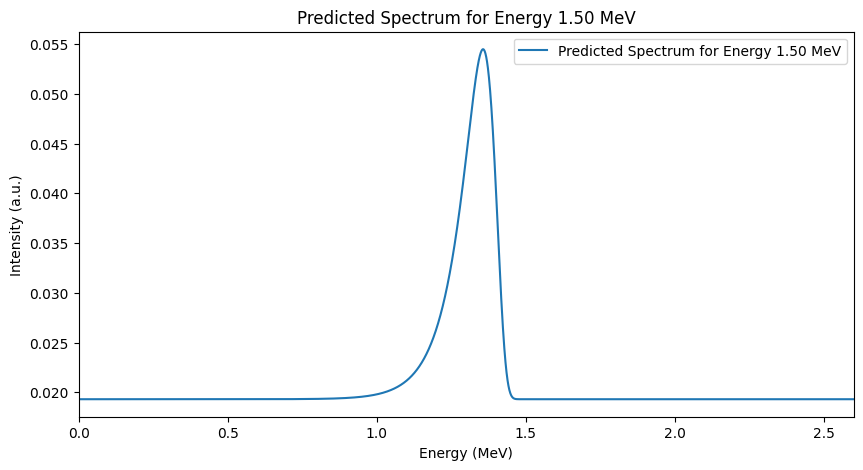

Predicted Parameters for Test Sample 6: I0=0.019308792427182198, A=0.05799106881022453, Ep=1.356688141822815, w=0.07467465102672577
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


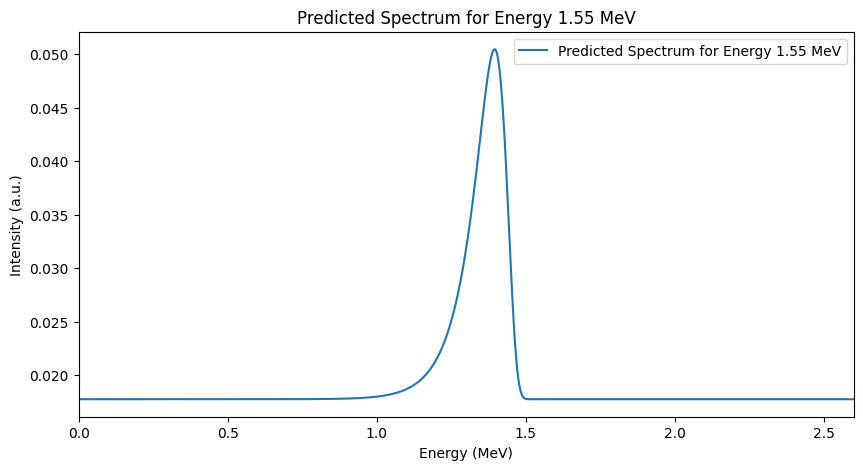

Predicted Parameters for Test Sample 7: I0=0.017763206735253334, A=0.05391724780201912, Ep=1.395355224609375, w=0.07306768745183945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


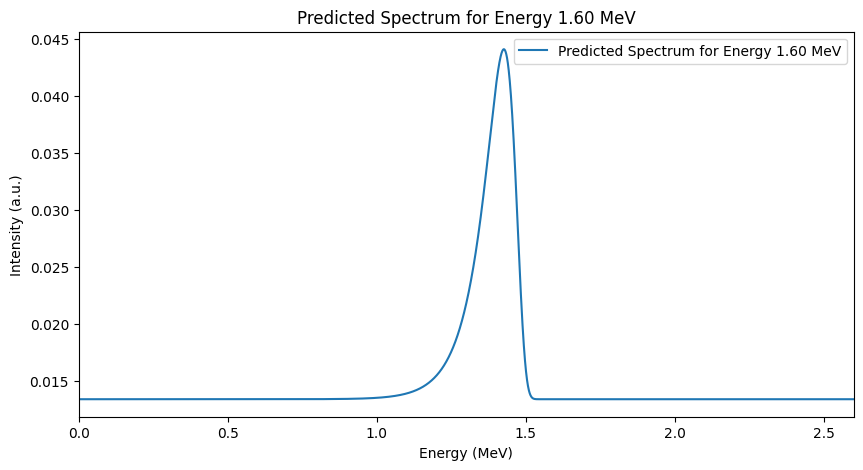

Predicted Parameters for Test Sample 8: I0=0.013390772044658661, A=0.05064072087407112, Ep=1.4260667562484741, w=0.07078906893730164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


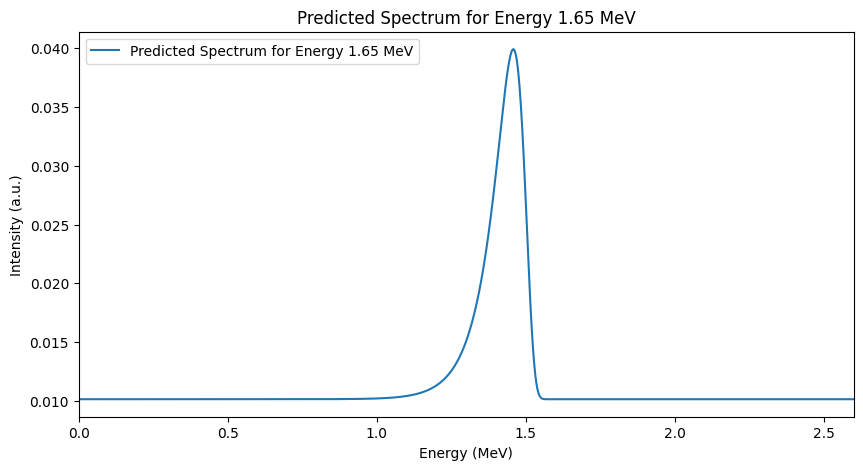

Predicted Parameters for Test Sample 9: I0=0.010140344500541687, A=0.04908037930727005, Ep=1.457785725593567, w=0.06904563307762146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


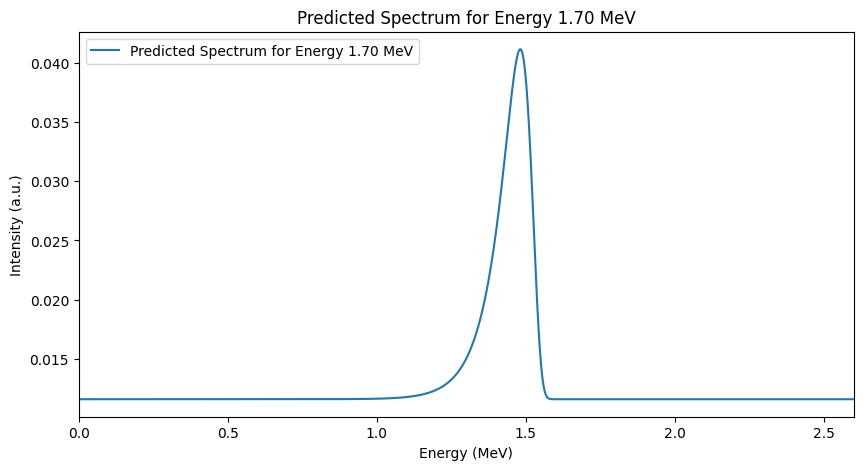

Predicted Parameters for Test Sample 10: I0=0.011570362374186516, A=0.04879581928253174, Ep=1.4812122583389282, w=0.06837800145149231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


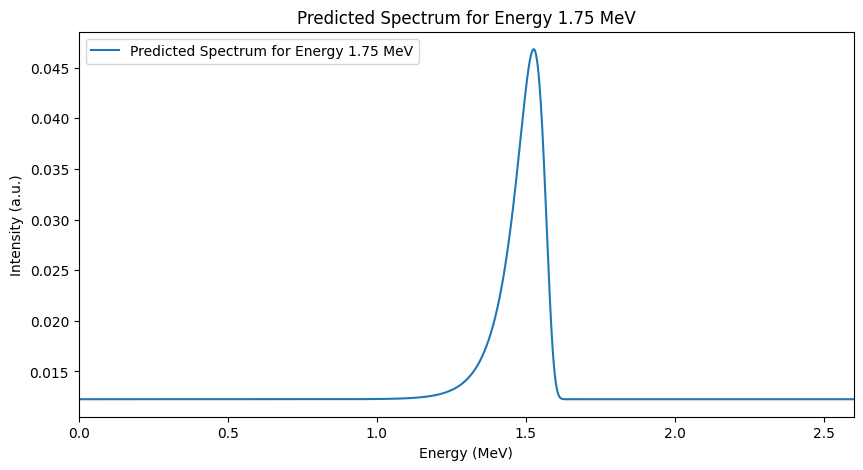

Predicted Parameters for Test Sample 11: I0=0.012256324291229248, A=0.05699077621102333, Ep=1.5260416269302368, w=0.06647242605686188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


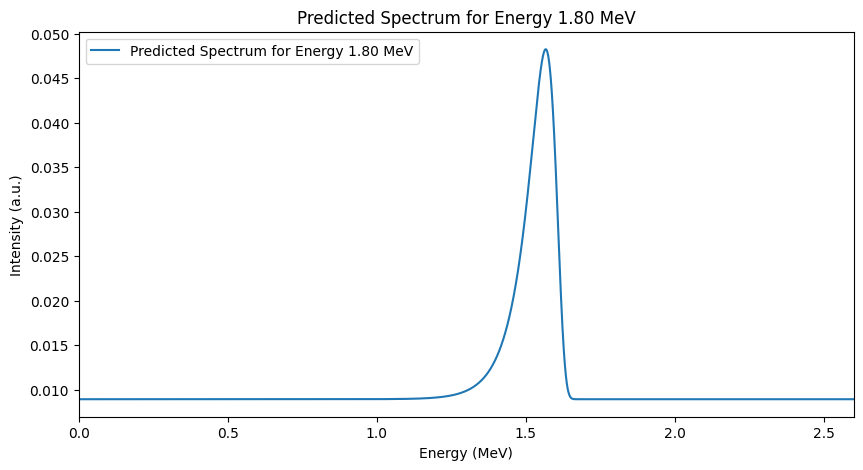

Predicted Parameters for Test Sample 12: I0=0.008923189714550972, A=0.0648137554526329, Ep=1.566518783569336, w=0.06303909420967102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


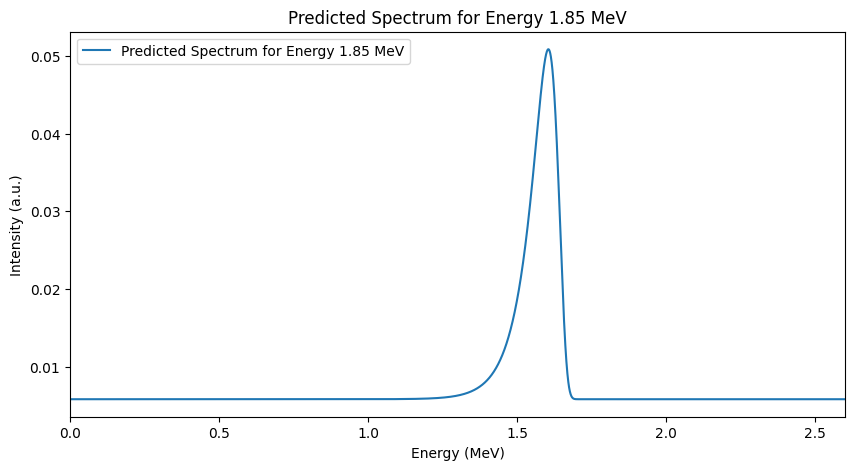

Predicted Parameters for Test Sample 13: I0=0.005811143666505814, A=0.07430125027894974, Ep=1.6047255992889404, w=0.06018320098519325
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


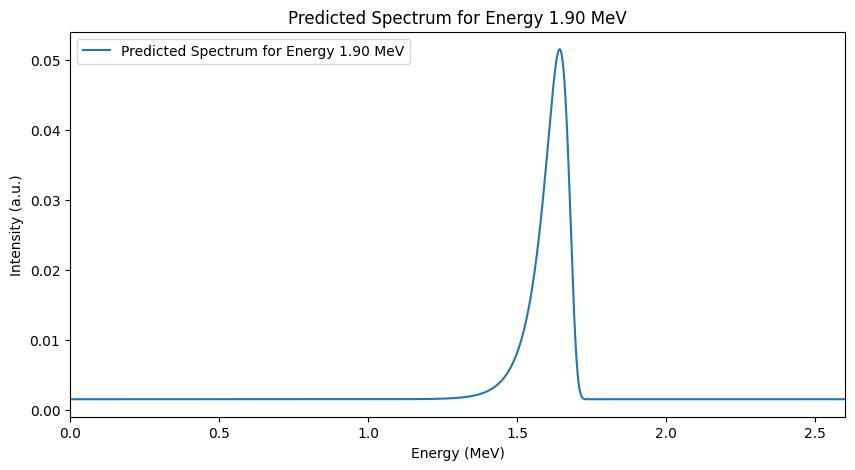

Predicted Parameters for Test Sample 14: I0=0.0015458259731531143, A=0.08242981135845184, Ep=1.6426578760147095, w=0.056715670973062515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


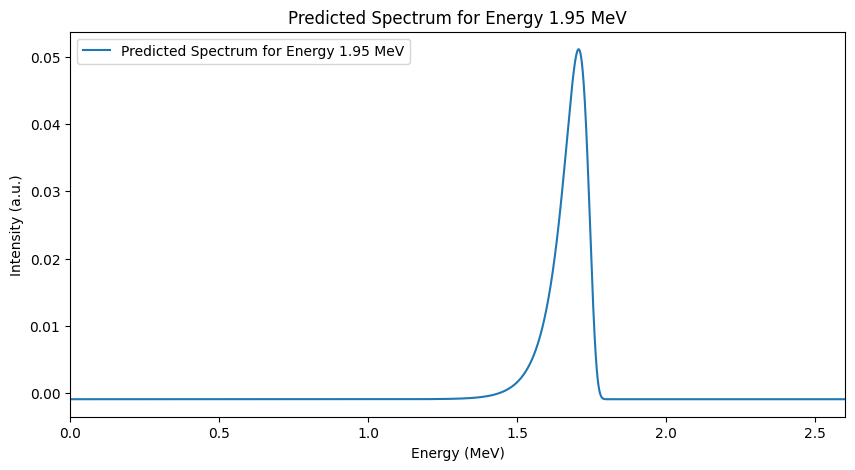

Predicted Parameters for Test Sample 15: I0=-0.0008682562038302422, A=0.08567941188812256, Ep=1.706235647201538, w=0.05854574590921402
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


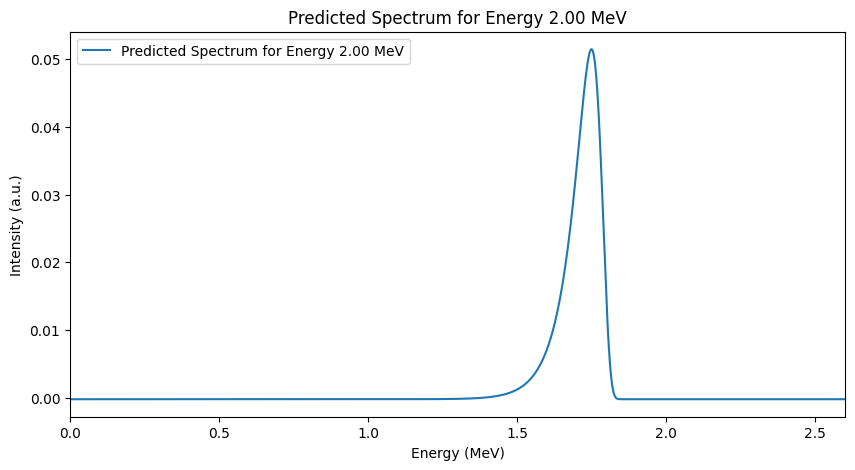

Predicted Parameters for Test Sample 16: I0=-0.0001914743334054947, A=0.08512066304683685, Ep=1.7494008541107178, w=0.061087481677532196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


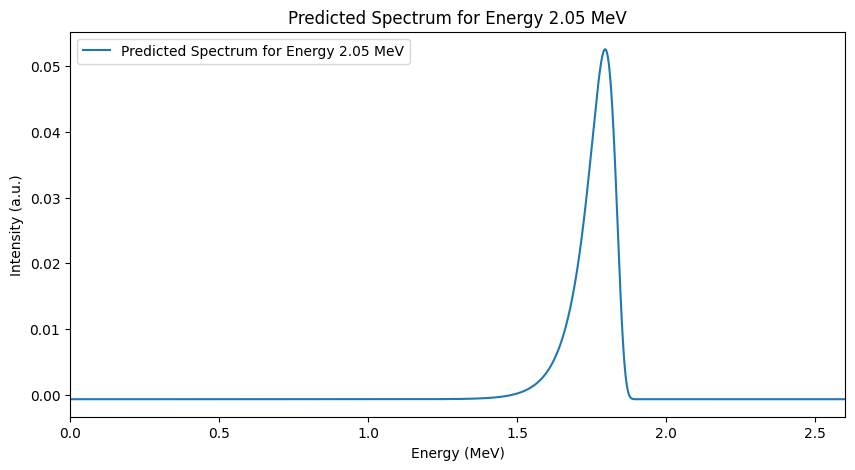

Predicted Parameters for Test Sample 17: I0=-0.0006224466487765312, A=0.0876065194606781, Ep=1.795212745666504, w=0.06394946575164795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


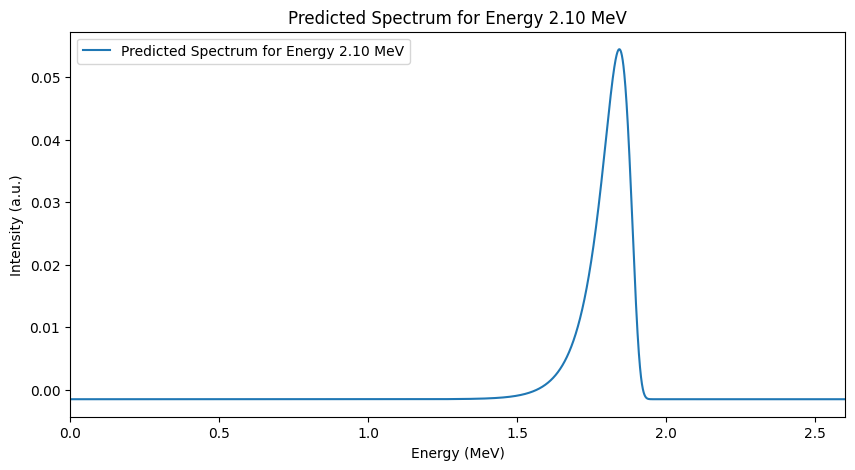

Predicted Parameters for Test Sample 18: I0=-0.0014959275722503662, A=0.09232903271913528, Ep=1.8427635431289673, w=0.0673777163028717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


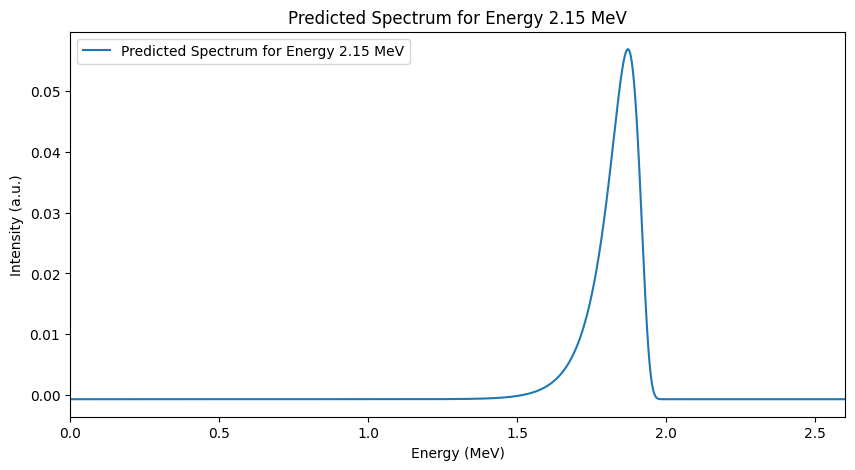

Predicted Parameters for Test Sample 19: I0=-0.0007200362160801888, A=0.09507270157337189, Ep=1.8715901374816895, w=0.07176975160837173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


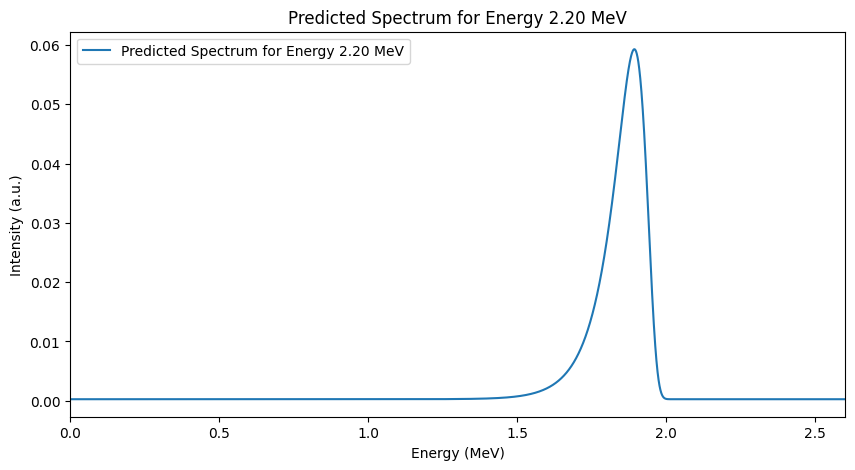

Predicted Parameters for Test Sample 20: I0=0.00025177188217639923, A=0.09734141081571579, Ep=1.8932132720947266, w=0.07398097217082977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


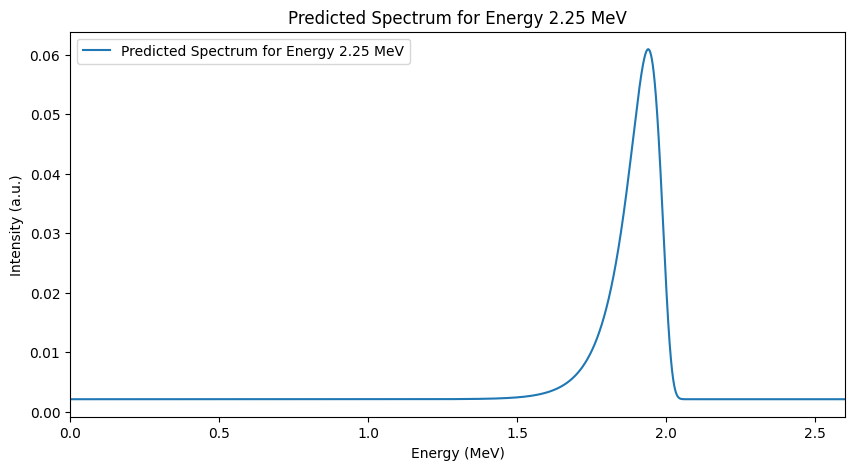

Predicted Parameters for Test Sample 21: I0=0.0021223388612270355, A=0.09698063880205154, Ep=1.9396710395812988, w=0.07656633108854294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


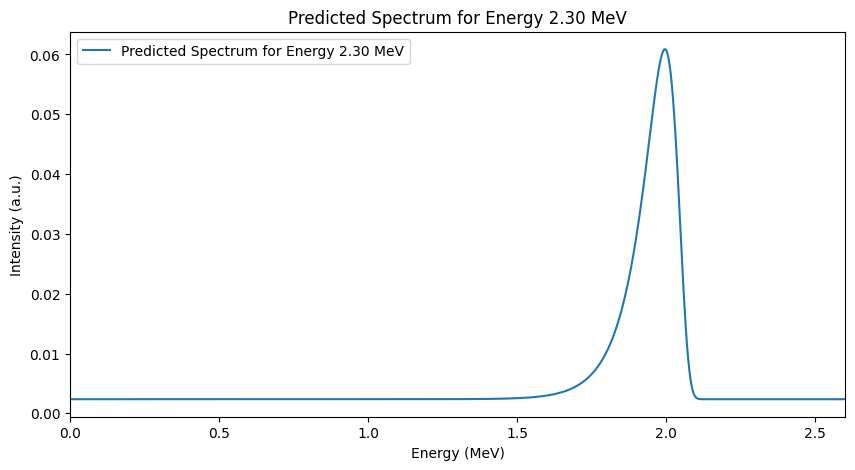

Predicted Parameters for Test Sample 22: I0=0.002356112003326416, A=0.09648705273866653, Ep=1.9957913160324097, w=0.07839234173297882
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


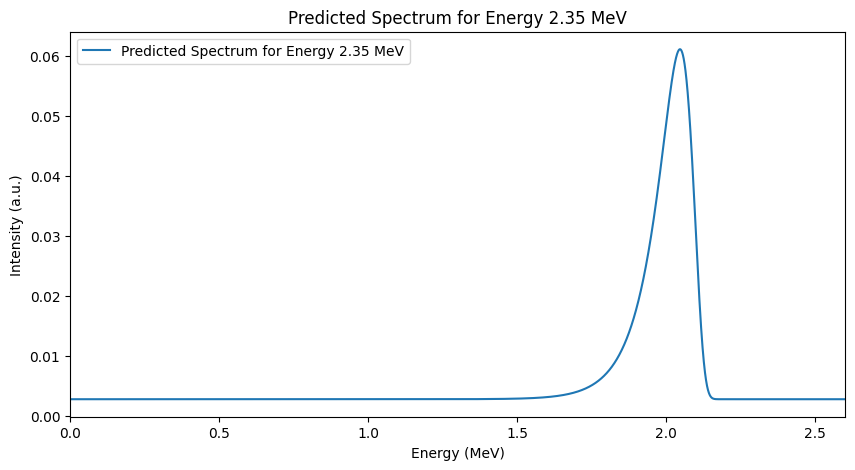

Predicted Parameters for Test Sample 23: I0=0.002775842323899269, A=0.09625736624002457, Ep=2.046271800994873, w=0.07948821038007736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


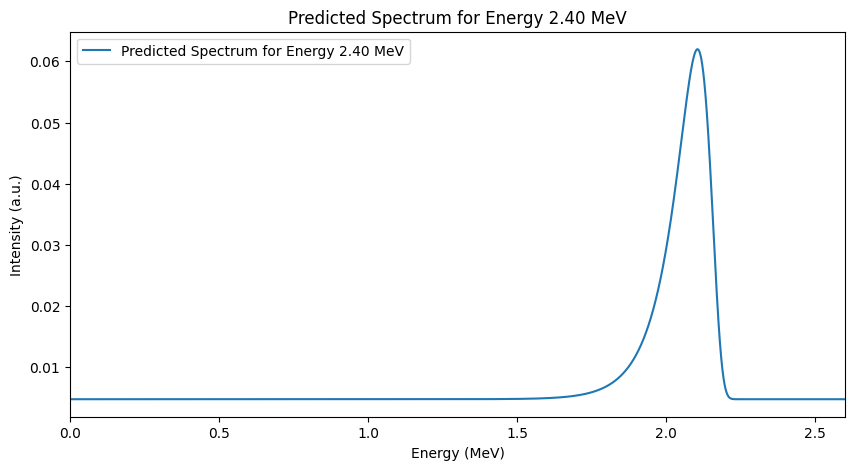

Predicted Parameters for Test Sample 24: I0=0.004780760034918785, A=0.09431051462888718, Ep=2.1050519943237305, w=0.08033355325460434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


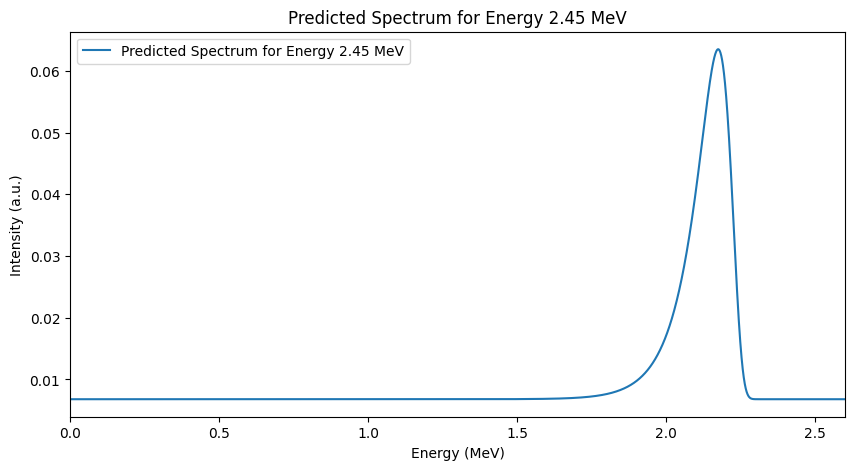

Predicted Parameters for Test Sample 25: I0=0.006799167022109032, A=0.09352288395166397, Ep=2.174375295639038, w=0.07933452725410461


In [175]:
# Đọc dữ liệu kiểm tra từ file test1.csv
df_test = pd.read_csv("test1.csv")
PDD_test = df_test.iloc[:, 1:].to_numpy()  # (48, 25)

# Chuẩn hóa dữ liệu kiểm tra
PDD_test_scaled = scaler_X.transform(PDD_test.T)  # Chuyển vị để mỗi cột là một mẫu

# Tạo dải năng lượng 
E_values = np.linspace(0, 2.6, 6000)

# Dự đoán các tham số từ dữ liệu kiểm tra và vẽ phổ năng lượng
for i in range(PDD_test_scaled.shape[0]):
    PDD_sample = PDD_test_scaled[i].reshape(1, -1)  # Định dạng lại để phù hợp đầu vào mô hình
    predicted_params = model.predict(PDD_sample)
    
    # Lấy các tham số dự đoán
    I0_pred, A_pred, Ep_pred, w_pred = predicted_params[0]
    
    # Tạo phổ năng lượng dự đoán từ các tham số trong dải năng lượng từ 0.0001 đến 1.1 MeV
    predicted_spectrum = modify_approximated_landau(E_values, I0_pred, A_pred, Ep_pred, w_pred)
    
    # Tính năng lượng cho mỗi cột
    energy_value = 1.25 + i * 0.05  
    
    # Vẽ phổ năng lượng dự đoán
    plt.figure(figsize=(10, 5))
    plt.plot(E_values, predicted_spectrum, label=f'Predicted Spectrum for Energy {energy_value:.2f} MeV')
    plt.xlim(0, 2.6)  
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Intensity (a.u.)')
    plt.title(f'Predicted Spectrum for Energy {energy_value:.2f} MeV')
    plt.legend()
    plt.grid(False)
    plt.show()
    
    # In các tham số dự đoán
    print(f'Predicted Parameters for Test Sample {i+1}: I0={I0_pred}, A={A_pred}, Ep={Ep_pred}, w={w_pred}')
